In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from read_db.CH import Getch
import pandas as pd
from datetime import datetime, timedelta

from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples

sns.set(rc={'figure.figsize': (16, 10)}, style='whitegrid', font_scale=0.8)

### Задача 1
Проводить исследования и интерпретировать их результаты - одна из главных задач аналитика, но для правильной постановки гипотезы нужно понимать, что происходит в данных.

Этим мы и займёмся - давайте познакомимся с нашими данными чуть ближе, чем названия колонок и их содержание! Первое, что мы можем сделать - это посчитать описательные статистики по лайкам и просмотрам.

Укажите, что из этого НЕ ХАРАКТЕРНО для наших данных. Возможно, вы догадаетесь о правильном ответе даже без описательных статистик :)

-1) По мерам центральной тенденции просмотры опережают лайки

+2) Медиана лайков приблизительно такая же, как и среднее по ним же

+3) Самые популярные посты собирают миллионы просмотров

In [2]:
query = """SELECT toStartOfDay(toDateTime(time)) AS ts,
        countIf(user_id, action='view') AS views,
        countIf(user_id, action='like') AS likes
    FROM simulator_20220320.feed_actions
    where toDate(time) < today()
    GROUP BY ts
    order by ts
    """

In [3]:
actions_df = Getch(query).df
actions_df.head()

,ts,views,likes
0,2022-02-16,8208,1880
1,2022-02-17,60906,13305
2,2022-02-18,125230,26996
3,2022-02-19,150516,32498
4,2022-02-20,179308,37450


In [4]:
central = actions_df.describe().loc[['mean','50%'], :]
central

,views,likes
mean,441010.813559,92043.40678
50%,461120.000000,97982.00000


In [5]:
central.views - central.likes

mean    348967.40678
50%     363138.00000
dtype: float64

Утверждение "1) По мерам центральной тенденции просмотры опережают лайки" является правдой, следовательно это характерно (а не НЕ ХАРАКТЕРНО) для наших данных. -

In [6]:
actions_df.likes.median(), actions_df.likes.mean()

(97982.0, 92043.40677966102)

In [7]:
relative_difference = (actions_df.likes.median() - actions_df.likes.mean()) / actions_df.likes.mean()
print(f"""{relative_difference * 100:,.3f}%""")

6.452%


Утверждение "2) Медиана лайков приблизительно такая же, как и среднее по ним же" сложно проверить из-за слова "приблизительно".

Однако наудачу было установлено, что это не характерно для наших данных. +

Post-hoc обоснованием может служить предположение, что слово "приблизительно" означает "относительная разница составляет 5% и менее".

In [8]:
posts_query = """SELECT post_id AS post_id,
                   countIf(action = 'view') AS views,
                   countIf(action = 'like') AS likes,
                   views / likes AS CTR,
                   count(DISTINCT user_id) AS uniq_users
                  FROM simulator_20220320.feed_actions
                  WHERE toDate(time) < today()
                  GROUP BY post_id"""

In [9]:
posts_df = Getch(posts_query).df

In [10]:
posts_df.views.max(), posts_df.views.max() >= 10**6

(89909, False)

Утверждение "3) Самые популярные посты собирают миллионы просмотров" ложно, значит это не характерно для наших данных. +

### Задача 2
Описательные статистики - это, конечно, хорошо. Но визуализация данных гораздо нагляднее!

Нарисуйте распределения просмотров и лайков. Какая у них форма и есть ли различия в этой форме? Выберите правильные варианты.

NB! Вам может помочь сравнение квантилей двух распределений через QQ-график. Перед этим их стоит z-стандартизовать, чтобы привести к общей шкале. Для большей наглядности советуем указать аргумент line="45". Отклонения от линии будут означать разницу в распределениях!

-1) В данных хорошо видны подгруппы

+2) Есть пик около нуля/единицы как для просмотров, так и для лайков

-3) Для данных характерна левосторонняя асимметрия

+4) Стандартизированные данные отличаются по своим правым "хвостам" - концам распределений

+5) Для данных характерна положительная асимметрия

In [11]:
def standartize_series(series):
    return (series - series.mean()) / series.std()

In [12]:
stdzd_posts_df = pd.DataFrame({'likes': standartize_series(posts_df.likes), 'views': standartize_series(posts_df.views)})

/nfs/env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


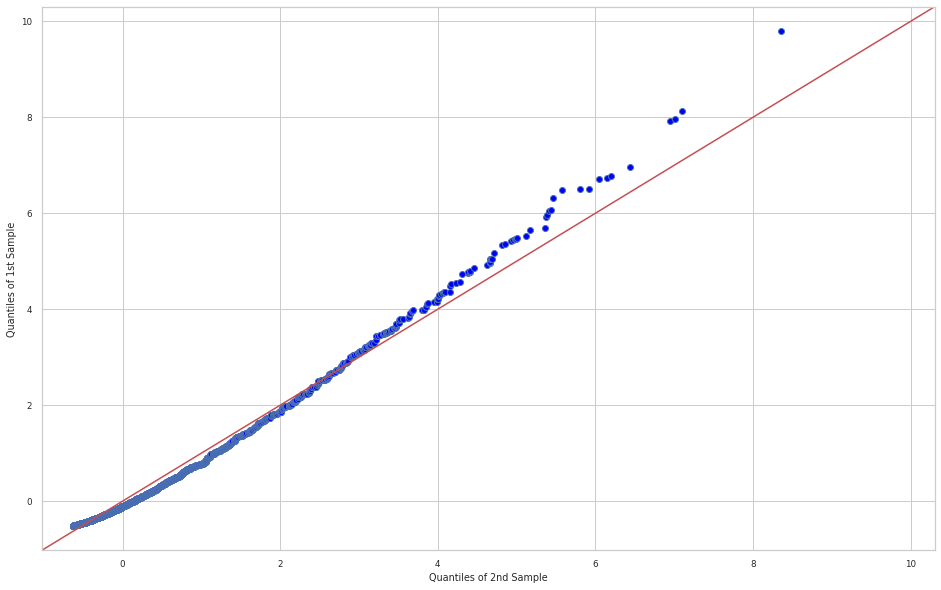

In [13]:
pp_x = sm.ProbPlot(stdzd_posts_df.likes)
pp_y = sm.ProbPlot(stdzd_posts_df.views)

qqplot_2samples(pp_x, pp_y, line="45");

4)Стандартизированные данные отличаются по своим правым "хвостам" - концам распределений $-$ правда (также это можно видеть на гистограммах, хоть и менее отчётливо).+

/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='views', ylabel='Density'>

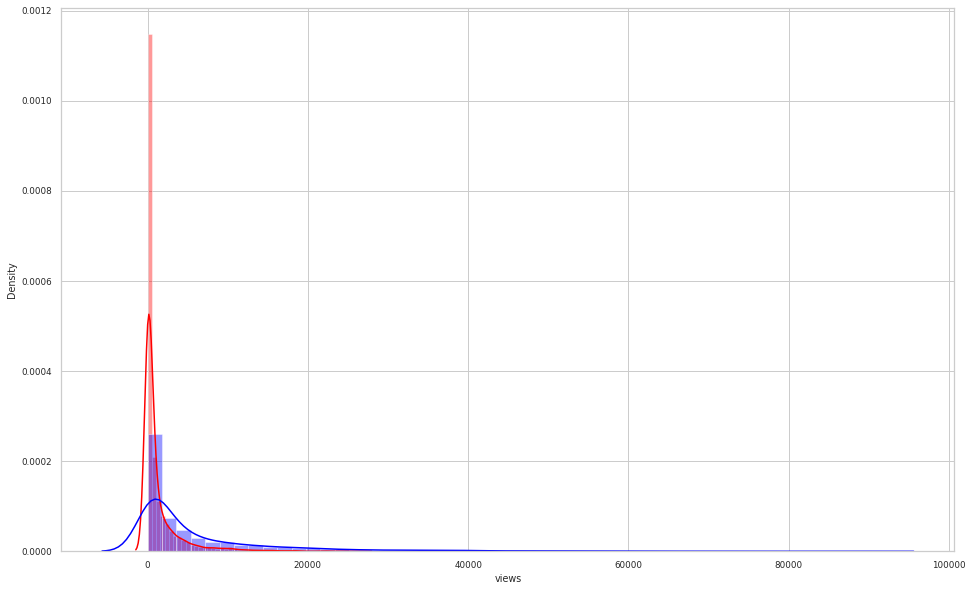

In [14]:
sns.distplot(posts_df.likes, color='red')
sns.distplot(posts_df.views, color='blue')

2)Есть пик около нуля/единицы как для просмотров, так и для лайков $-$ правда.+

array([[<AxesSubplot:xlabel='likes', ylabel='likes'>,
        <AxesSubplot:xlabel='views', ylabel='likes'>],
       [<AxesSubplot:xlabel='likes', ylabel='views'>,
        <AxesSubplot:xlabel='views', ylabel='views'>]], dtype=object)

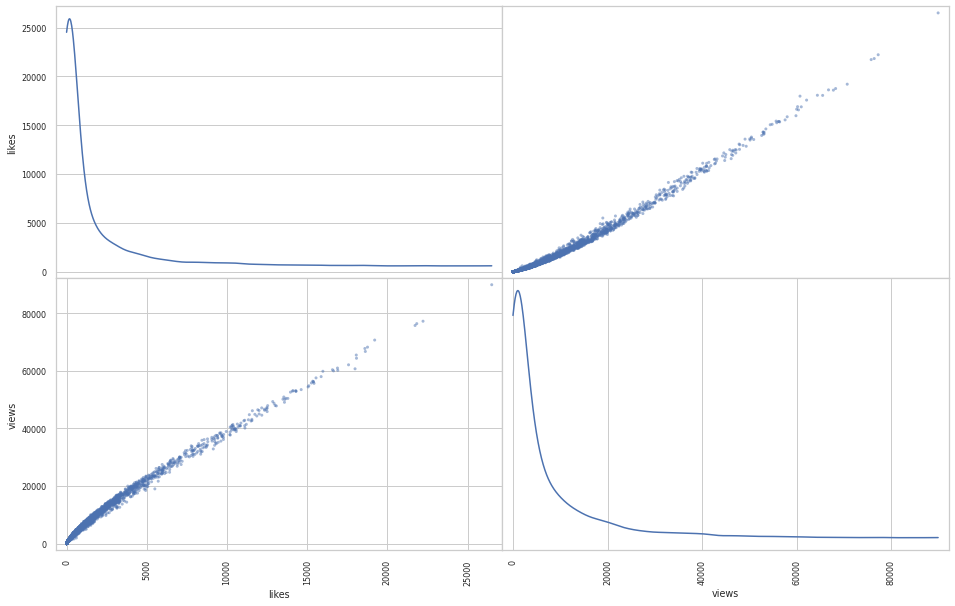

In [15]:
pd.plotting.scatter_matrix(posts_df[['likes', 'views']], diagonal='kde')

3)Для данных характерна левосторонняя асимметрия $-$ ложь.-

5)Для данных характерна положительная асимметрия $-$ правда.+

(Заявления взаимно исключающие, положительная/правосторонняя ассиметрия означает горб слева [по отношению к симметричному].)

1)В данных хорошо видны подгруппы $-$ ложь, так как подгрупп не видно нигде.-

<AxesSubplot:xlabel='views', ylabel='Count'>

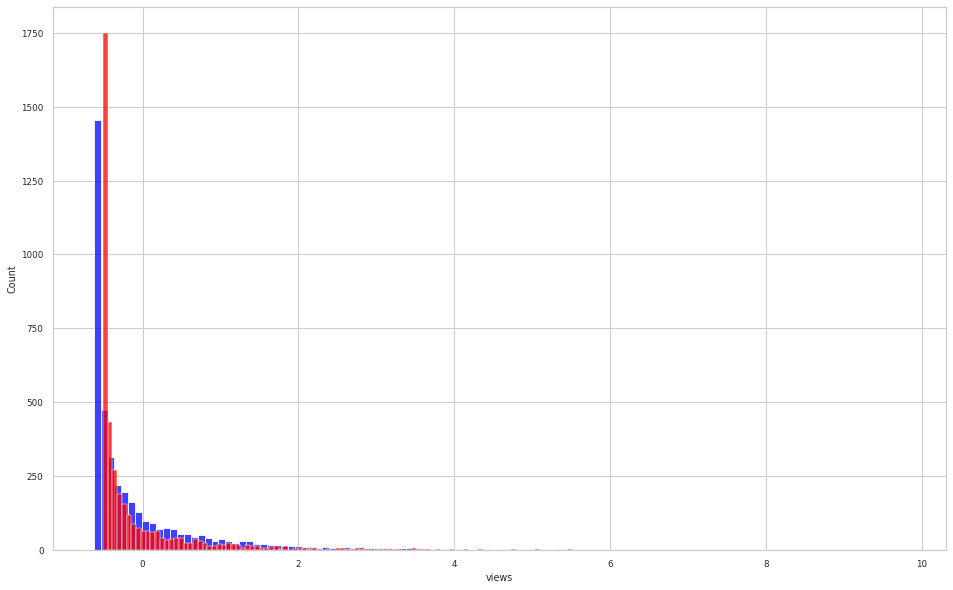

In [16]:
sns.histplot(stdzd_posts_df.views, color='blue')
sns.histplot(stdzd_posts_df.likes, color='red')

array([[<AxesSubplot:xlabel='likes', ylabel='likes'>,
        <AxesSubplot:xlabel='views', ylabel='likes'>],
       [<AxesSubplot:xlabel='likes', ylabel='views'>,
        <AxesSubplot:xlabel='views', ylabel='views'>]], dtype=object)

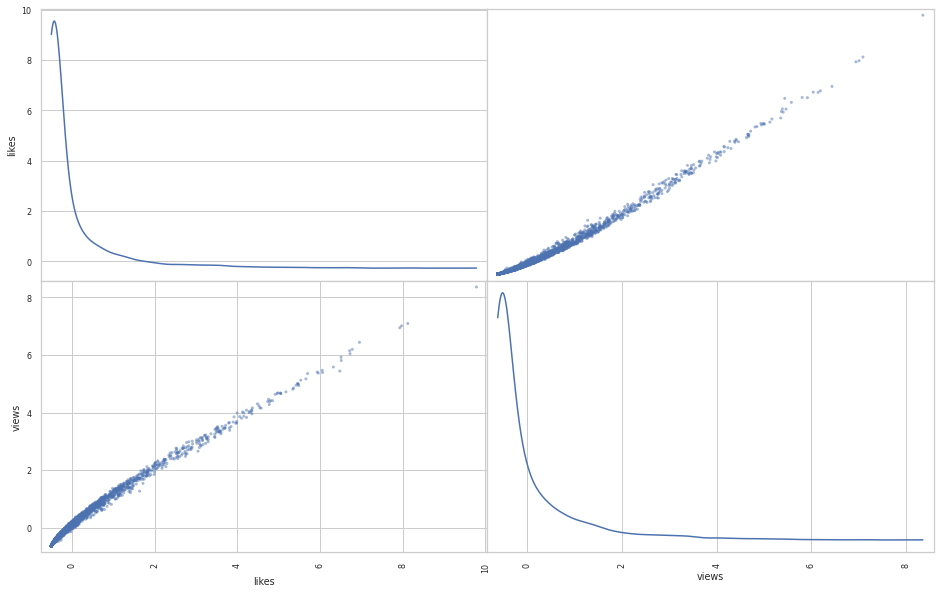

In [17]:
pd.plotting.scatter_matrix(stdzd_posts_df, diagonal='kde')

### Задача 3
"Сырые" лайки и просмотры могут быть познавательными сами по себе, но качество поста можно оценить не только по ним. Полезной может оказаться такая метрика как CTR - в данном случае это отношение количества лайков ко всем просмотрам данного поста. Также важную информацию может дать время существования поста - насколько продолжительное время конкретный пост смотрят и лайкают.

Посчитайте CTR и время существования для каждого из постов (от первого просмотра поста). Затем:

Нарисуйте их распределения

Постройте корреляционную матрицу между ними, просмотрами и лайками

Визуализируйте все эти взаимосвязи в виде диаграмм рассеяния

Какие суждения об этих величинах верны? Суждение может быть одно, а может быть несколько.

-1) Между количеством лайков и временем существования поста связь линейная

+2) По сравнению с просмотрами и лайками CTR менее асимметричен

-3) В среднем посты "живут" пять дней

-4) Сильнее всего коррелируют CTR и время существования поста

In [18]:
posts_query = """SELECT post_id AS post_id,
       countIf(action = 'view') AS views,
       countIf(action = 'like') AS likes,
       likes / views AS "CTR",
       count(DISTINCT user_id) AS uniq_users,
       min(time) as start_date,
       max(time) as fin_date,
       dateDiff('minute', start_date, fin_date) as lifetime
FROM simulator_20220320.feed_actions
GROUP BY post_id"""

In [19]:
posts_df = Getch(posts_query).df

In [20]:
posts_df.lifetime = posts_df.lifetime / (24 * 60)

In [21]:
posts_df.lifetime.mean()

1.6090949928929654

3)В среднем посты "живут" пять дней $-$ ложь.-

array([[<AxesSubplot:xlabel='views', ylabel='views'>,
        <AxesSubplot:xlabel='likes', ylabel='views'>,
        <AxesSubplot:xlabel='CTR', ylabel='views'>,
        <AxesSubplot:xlabel='lifetime', ylabel='views'>],
       [<AxesSubplot:xlabel='views', ylabel='likes'>,
        <AxesSubplot:xlabel='likes', ylabel='likes'>,
        <AxesSubplot:xlabel='CTR', ylabel='likes'>,
        <AxesSubplot:xlabel='lifetime', ylabel='likes'>],
       [<AxesSubplot:xlabel='views', ylabel='CTR'>,
        <AxesSubplot:xlabel='likes', ylabel='CTR'>,
        <AxesSubplot:xlabel='CTR', ylabel='CTR'>,
        <AxesSubplot:xlabel='lifetime', ylabel='CTR'>],
       [<AxesSubplot:xlabel='views', ylabel='lifetime'>,
        <AxesSubplot:xlabel='likes', ylabel='lifetime'>,
        <AxesSubplot:xlabel='CTR', ylabel='lifetime'>,
        <AxesSubplot:xlabel='lifetime', ylabel='lifetime'>]], dtype=object)

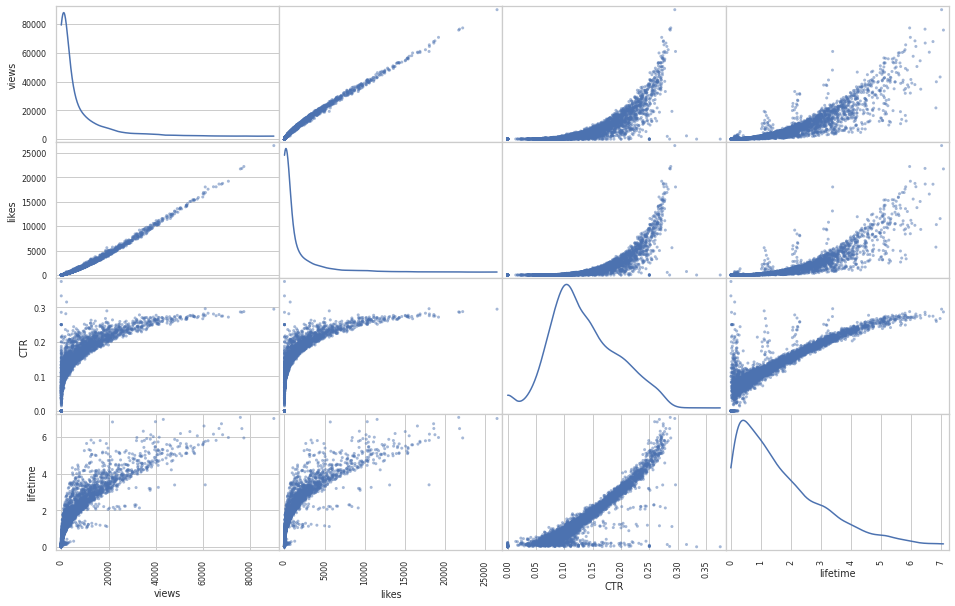

In [22]:
plot_df = posts_df[['views','likes','CTR','lifetime']]

pd.plotting.scatter_matrix(plot_df, diagonal='kde')

In [23]:
plot_df.corr()

,views,likes,CTR,lifetime
views,1.000000,0.991093,0.783188,0.859012
likes,0.991093,1.000000,0.735806,0.817113
CTR,0.783188,0.735806,1.000000,0.902998
lifetime,0.859012,0.817113,0.902998,1.000000


In [24]:
plot_df.CTR.skew(), plot_df.views.skew(), plot_df.likes.skew()

(0.32989202312300636, 2.871869771125175, 3.559072941302971)

1)Между количеством лайков и временем существования поста связь линейная $-$ ложь.-

2)По сравнению с просмотрами и лайками CTR менее асимметричен $-$ правда.+

4)Сильнее всего коррелируют CTR и время существования поста $-$ ложь (сильнее всего коррелируют лайки с просмотрами).-

### Задача 4
Всё это время мы оценивали наши данные "в статике". Давайте теперь обратимся к их динамике! Попробуем определить, что вообще приводит к изменениям в наших метриках - в самом первом приближении.

Нарисуйте дневную динамику активности уникальных пользователей, а затем просмотра уникальных постов. Соотнесите:

Уникальные пользователи -- Постоянный рост с небольшими флуктуациями

Просмотры уникальных постов -- Резкий рост в начале, затем случайные колебания вокруг одного уровня

In [25]:
uniq_users_query = """select toDate(time) as date,
                            count(distinct user_id) as users
                      from simulator_20220320.feed_actions
                      where toDate(time) < today()
                      group by date
                      order by date
"""

In [26]:
uniq_users = Getch(uniq_users_query).df
# uniq_users

<AxesSubplot:xlabel='date', ylabel='users'>

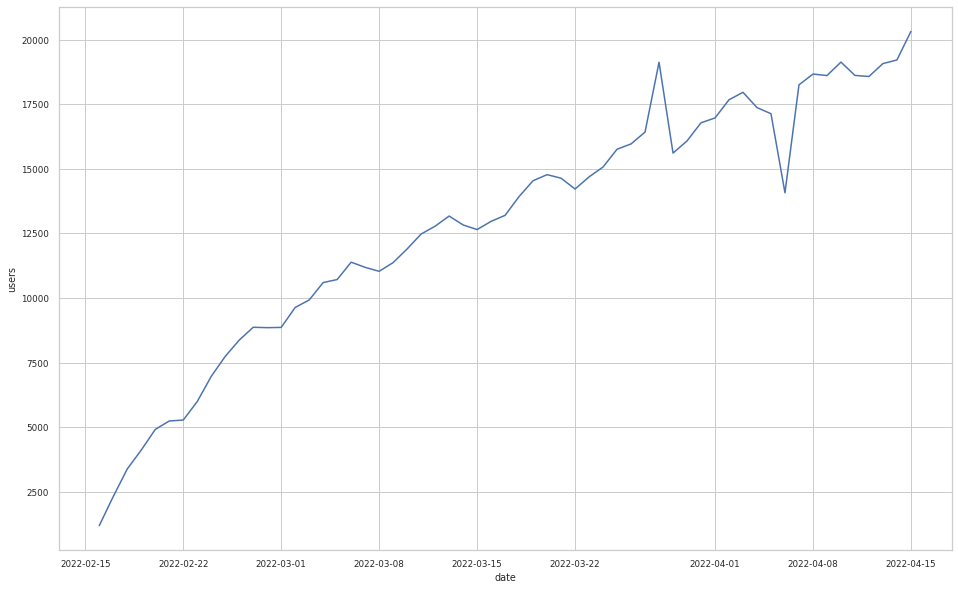

In [27]:
sns.lineplot(data=uniq_users, x='date', y='users')

### Задача 5
Мы посмотрели как на вклад пользователей, так и вклад постов в общую динамику просмотров и лайков. Однако не менее полезной может оказаться декомпозиция временного ряда на компоненты - чтобы выделить отдельные составляющие части процесса.

Возьмите почасовую динамику активности за весь период и проанализируйте её этой функцией. Соотнесите получившийся результат с его интерпретацией:

Первый график -- Оригинальный временной ряд

Второй график -- Общий тренд активности

Третий график -- Повторяющиеся дневные регулярности в данных

Четвёртый график -- Остатки модели

In [28]:
last_day_atom_s = 60 * 60

feed_query="""SELECT toDateTime(intDiv(toUInt32(toDateTime(time)), {atom_s})*{atom_s}) AS ts,
                  count(user_id) AS actions
              FROM simulator_20220320.feed_actions
              WHERE toDate(time) < today()
              GROUP BY ts
              order by ts
              """.format(atom_s=last_day_atom_s)

In [29]:
feed_df = Getch(feed_query).df

In [30]:
# from statsmodels.datasets import co2
# data = co2.load(True).data
#data

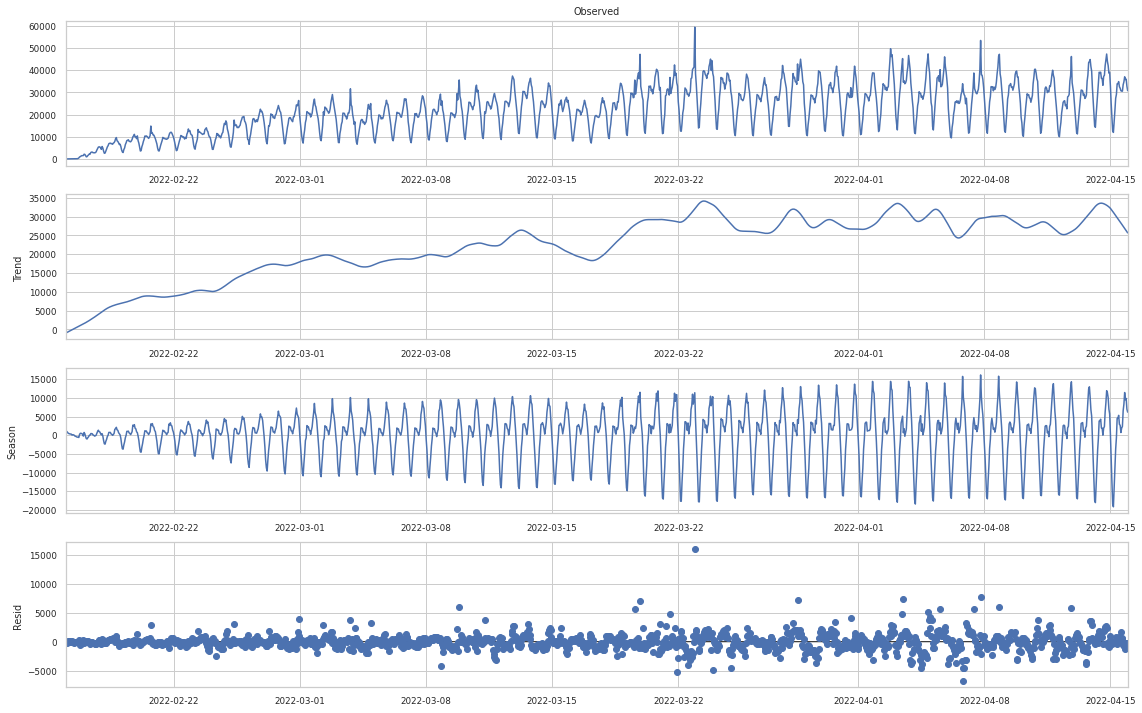

In [31]:
res = STL(feed_df.set_index('ts')).fit()
res.plot();

(Это задание можно выполнить, просто посмотрев на страницу документации.)

[Однако опыт перевода фрейма во временной ряд является полезным.]

### Задача 6
Вы могли заметить из прошлого задания, что просмотры постов "колеблются" в течение дня. Вопрос: а отличается ли распределение дневной активности пользователей от распределения публикации постов? В качестве прокси времени публикации возьмите время первого просмотра поста.

Визуализируйте оба распределения для каждого часа дня и выберите правильные варианты ответа:

+1) Пики активности пользователей и публикации постов не совпадают

-2) Наименьшая активность пользователей наблюдается в 5 утра

-3) Посты публикуются круглосуточно

+4) Больше всего постов публикуется в районе 8 вечера

-5) Для активности пользователей характерен линейный рост в течение дня, сопровождающийся падением

+6) Примерно с 9 утра до 4 вечера активность пользователей одинаковая, с небольшой "просадкой" посередине

In [32]:
one_h_atom_s = 60 * 60

q_p = """SELECT post_id AS post_id,
           toDateTime(intDiv(toUInt32(toDateTime(min(time))), {atom_s})*{atom_s}) as start_date
        FROM simulator_20220320.feed_actions
        where toDate(time) < today()
        GROUP BY post_id""".format(atom_s=one_h_atom_s)

u_p = """SELECT toDateTime(intDiv(toUInt32(toDateTime(time)), {atom_s})*{atom_s}) AS ts,
           count(action) AS actions
        FROM simulator_20220320.feed_actions
        where toDate(time) < today()
        GROUP BY ts""".format(atom_s=one_h_atom_s)

In [33]:
p_df = Getch(q_p).df

u_df = Getch(u_p).df

In [34]:
p = p_df.groupby('start_date').post_id.count()
p

start_date
2022-02-16 00:00:00     3
2022-02-16 12:00:00     1
2022-02-16 14:00:00     3
2022-02-16 15:00:00     4
2022-02-16 16:00:00     5
                       ..
2022-04-15 19:00:00    10
2022-04-15 20:00:00     6
2022-04-15 21:00:00    12
2022-04-15 22:00:00     9
2022-04-15 23:00:00     3
Name: post_id, Length: 726, dtype: int64

In [35]:
u = u_df.set_index('ts').actions
u

ts
2022-03-12 22:00:00    31072
2022-03-05 15:00:00    19245
2022-03-10 01:00:00    17758
2022-03-26 11:00:00    28452
2022-03-24 00:00:00    31778
                       ...  
2022-03-29 11:00:00    28546
2022-04-06 14:00:00    25044
2022-04-08 14:00:00    31359
2022-03-26 03:00:00    11153
2022-03-16 18:00:00    24589
Name: actions, Length: 1416, dtype: uint64

In [36]:
date = '2022-04-01'

In [37]:
p[date].idxmax() == u[date].idxmax(), p[date].idxmax(), u[date].idxmax()

(False, Timestamp('2022-04-01 18:00:00'), Timestamp('2022-04-01 19:00:00'))

In [38]:
ups = [u[d.strftime('%Y-%m-%d')].idxmax() == p[d.strftime('%Y-%m-%d')].idxmax() for d in u.index.date]

In [39]:
for x in zip(*np.unique(ups, return_counts=True)):
    print(x)

(False, 1176)
(True, 240)


1)Пики активности пользователей и публикации постов не совпадают $-$ правда (или хотя бы "в большинстве случаев правда").+

In [40]:
u[date].idxmin()

Timestamp('2022-04-01 03:00:00')

In [41]:
u_downs = [u[d.strftime('%Y-%m-%d')].idxmin().strftime('%H:%M') for d in u.index.date]

In [42]:
for x in zip(*np.unique(u_downs, return_counts=True)):
    print(x)

('03:00', 312)
('04:00', 1104)


2)Наименьшая активность пользователей наблюдается в 5 утра $-$ ложь (и через наивное обоснование "у выбранной даты минимум активности не в 5 утра", и через проверку всех дней).-

In [43]:
post_times = [d.strftime('%H:%M') for d in p.index.time]

In [44]:
for x in zip(*np.unique(post_times, return_counts=True)):
    print(x)

('00:00', 51)
('01:00', 33)
('02:00', 7)
('09:00', 1)
('10:00', 3)
('11:00', 8)
('12:00', 12)
('13:00', 35)
('14:00', 51)
('15:00', 56)
('16:00', 56)
('17:00', 59)
('18:00', 59)
('19:00', 59)
('20:00', 59)
('21:00', 59)
('22:00', 59)
('23:00', 59)


3)Посты публикуются круглосуточно $-$ ложь, часы между 3 и 8 включительно в списке времени публикаций не фигурируют.-

<AxesSubplot:xlabel='start_date', ylabel='post_id'>

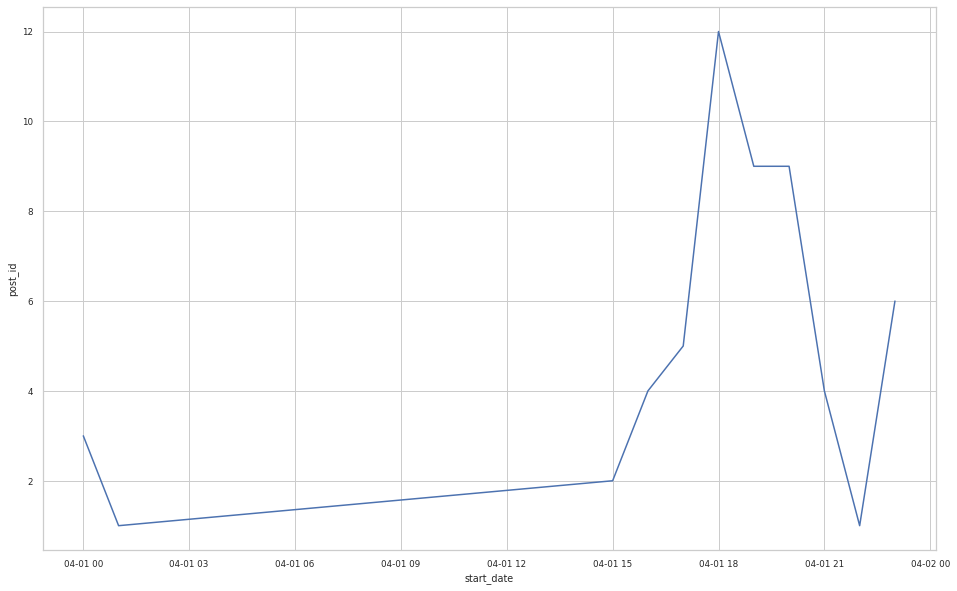

In [45]:
sns.lineplot(data=p[date])

In [46]:
p[date].sort_index()

start_date
2022-04-01 00:00:00     3
2022-04-01 01:00:00     1
2022-04-01 15:00:00     2
2022-04-01 16:00:00     4
2022-04-01 17:00:00     5
2022-04-01 18:00:00    12
2022-04-01 19:00:00     9
2022-04-01 20:00:00     9
2022-04-01 21:00:00     4
2022-04-01 22:00:00     1
2022-04-01 23:00:00     6
Name: post_id, dtype: int64

In [47]:
p_ups = [p[d.strftime('%Y-%m-%d')].idxmax().strftime('%H:%M') for d in p.index.date]

In [48]:
for x in zip(*np.unique(p_ups, return_counts=True)):
    print(x)

('17:00', 25)
('18:00', 120)
('19:00', 174)
('20:00', 225)
('21:00', 158)
('22:00', 24)


4)Больше всего постов публикуется в районе 8 вечера $-$ правда.+

<AxesSubplot:xlabel='ts', ylabel='actions'>

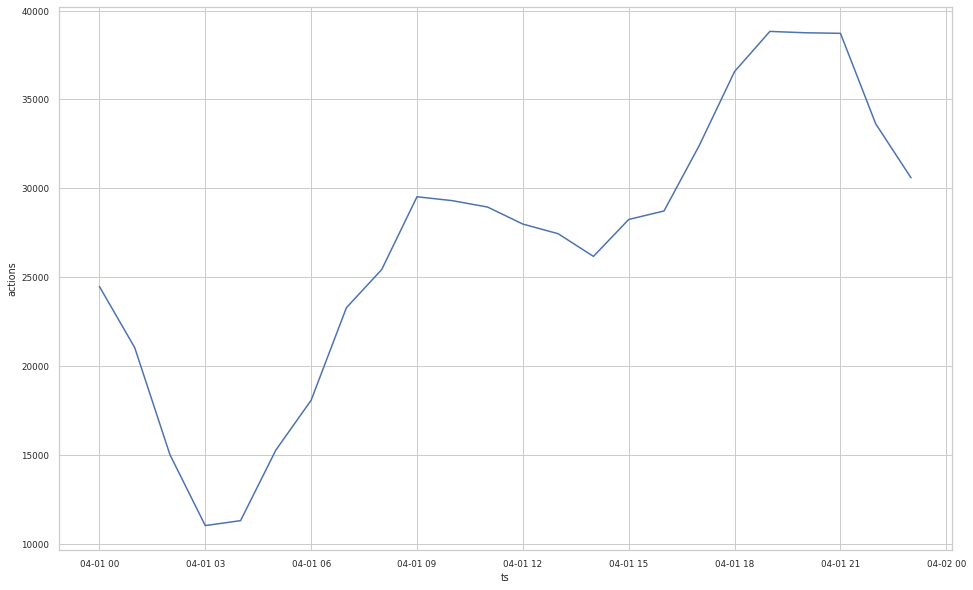

In [49]:
sns.lineplot(data=u[date])

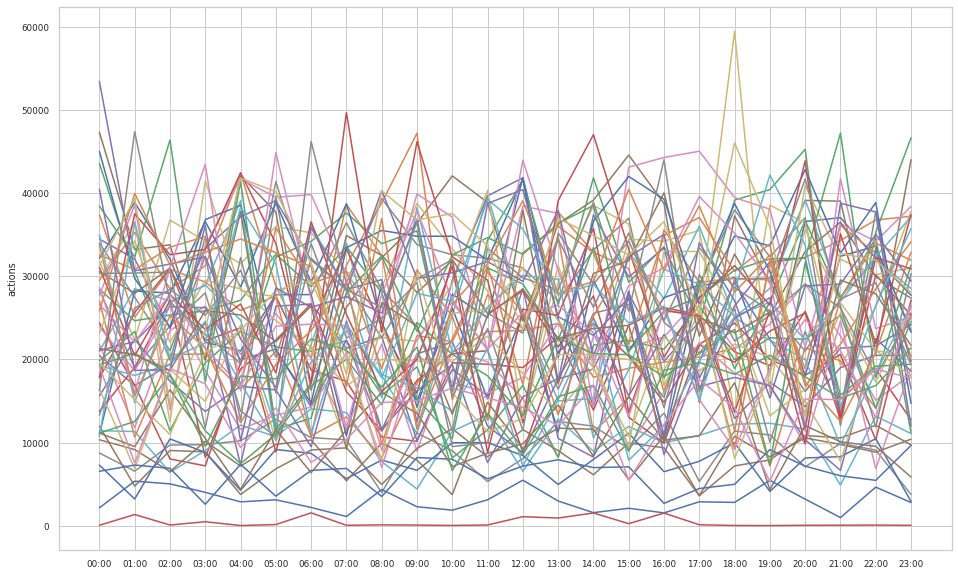

In [50]:
for day in {d.strftime('%Y-%m-%d') for d in u.index.date}:
    time = [t.strftime('%H:%M') for t in u[day].sort_index().index]
    sns.lineplot(y=u[day], x=time)

5)Для активности пользователей характерен линейный рост в течение дня, сопровождающийся падением $-$ ложь, зависимость является более сложной (что видно на графике одного дня лучше, чем на графике за все дни, однако и на последнем мы видим, если вообще что-то видим, нелинейность в течение дня).-

In [51]:
for t in [t for t in u.loc['2022-04-02'].index.time if t.hour in range(9,17)]:
    # print(u[t])
    pass

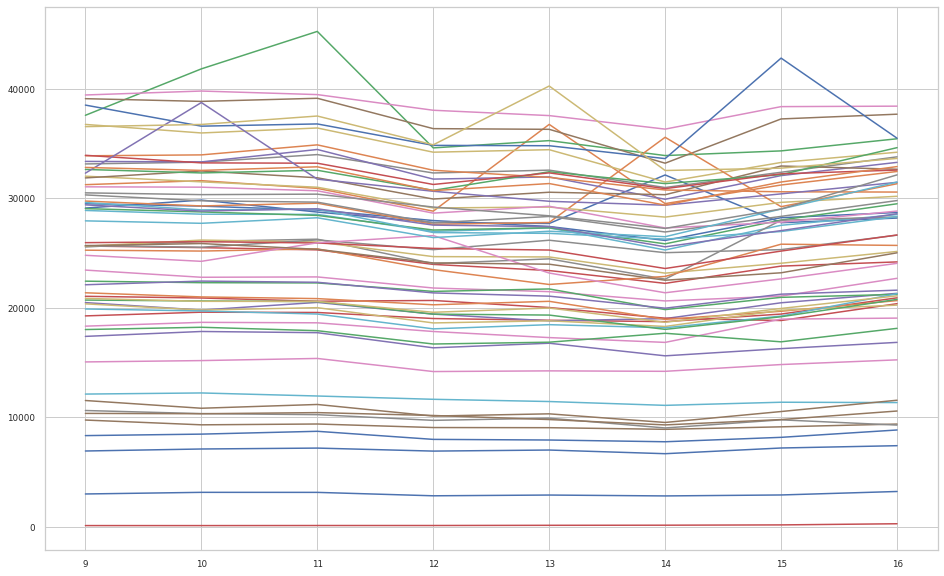

In [52]:
for day in {d.strftime('%Y-%m-%d') for d in u.index.date}:
    time = [t for t in u[day].index if t.hour in range(9,17)]
    activity = [u[t] for t in time]
    sns.lineplot(y=activity, x=[t.hour for t in time])

6)Примерно с 9 утра до 4 вечера активность пользователей одинаковая, с небольшой "просадкой" посередине $-$ правда (или хотя бы что-то похожее на неё).+